In [6]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(16,6)}, style = 'whitegrid')

In [7]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [21]:
delivery_picture = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_1.csv')

# Первый эксперимент (картинки) 

In [9]:
delivery_picture.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

A – прямоугольные 16:9
B – квадратные
C – прямоугольные 12:4
Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?

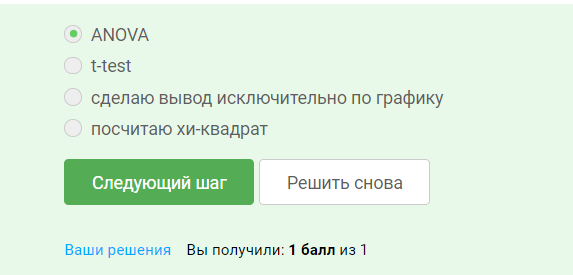

Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

Hint: scipy.stats.levene

In [10]:
a_var = delivery_picture.query("group == 'A'").events
b_var = delivery_picture.query("group == 'B'").events
c_var = delivery_picture.query("group == 'C'").events

In [11]:
ss.levene(a_var, b_var, c_var)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

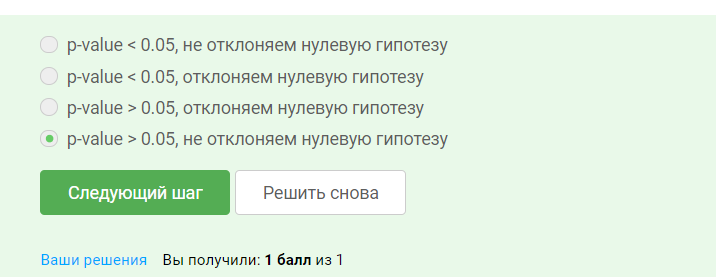

Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample.

In [12]:
ss.shapiro(a_var.sample(1000, random_state = 17))

(0.9973153471946716, 0.09609563648700714)

In [13]:
ss.shapiro(b_var.sample(1000, random_state = 17))

(0.9980798363685608, 0.31768906116485596)

In [14]:
ss.shapiro(c_var.sample(1000, random_state = 17))

(0.9981185793876648, 0.3359004259109497)

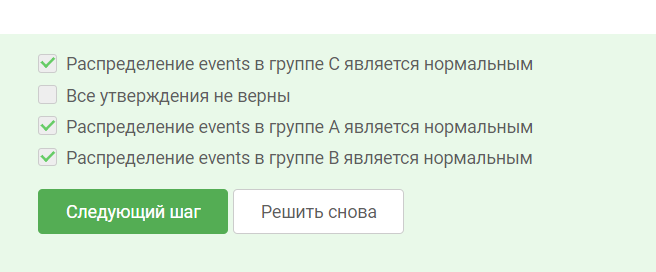

Самое время провести тест! 

In [15]:
ss.f_oneway(a_var, b_var, c_var)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [18]:
round(ss.f_oneway(a_var, b_var, c_var)[0])

2886.0

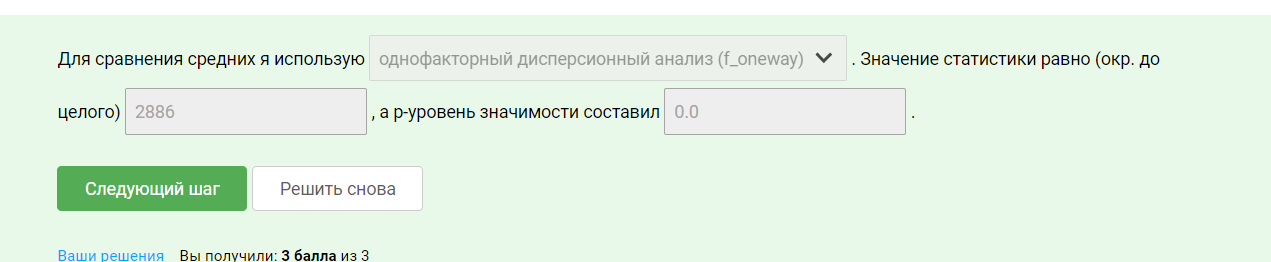

Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 



In [20]:
print(pairwise_tukeyhsd(delivery_picture.events, groups = delivery_picture.group)).summary()

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


AttributeError: 'NoneType' object has no attribute 'summary'

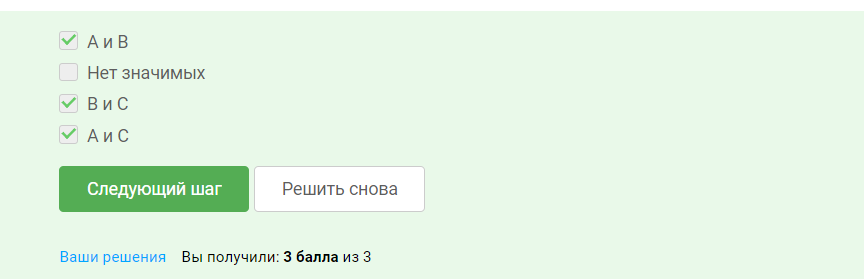

Так какие картинки в итоге будем использовать?



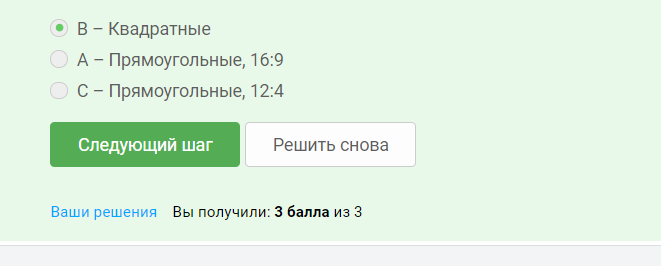

# Второй эксперимент (кнопка) 

In [22]:
delivery_button = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_2.csv')

In [23]:
delivery_button.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Какой метод скорее всего пригодится в данном случае?

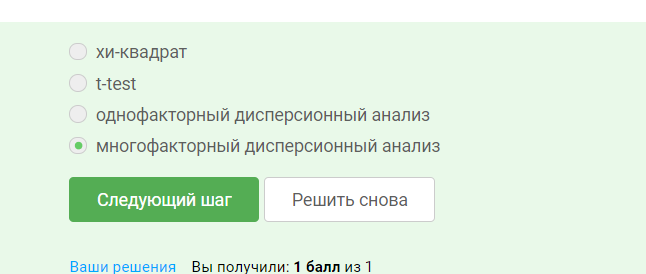

Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп. Соотнесите графики распределения и экспериментальные группы:
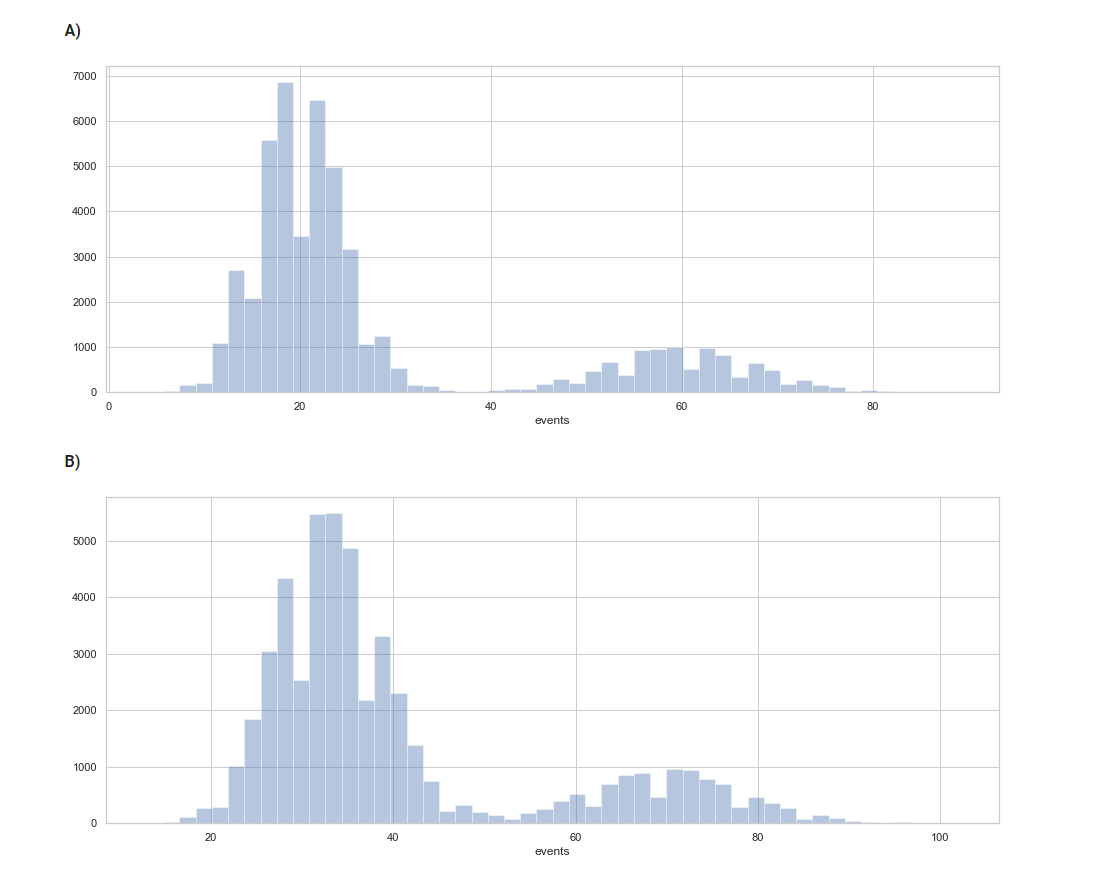

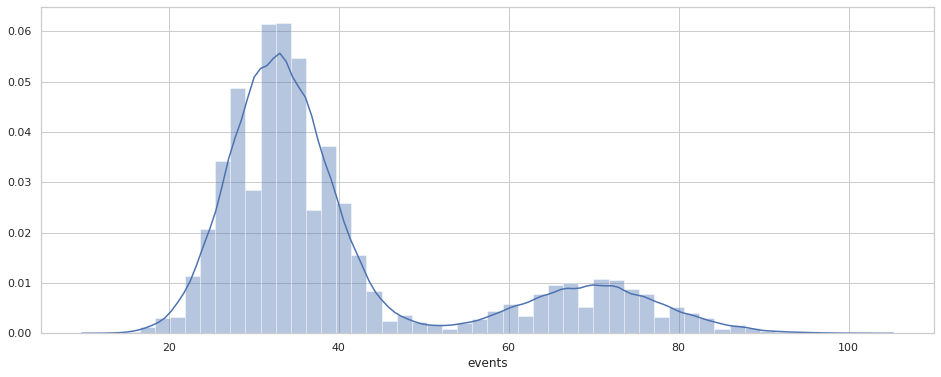

In [27]:
sns.distplot(delivery_button.query('group == "test"').events);

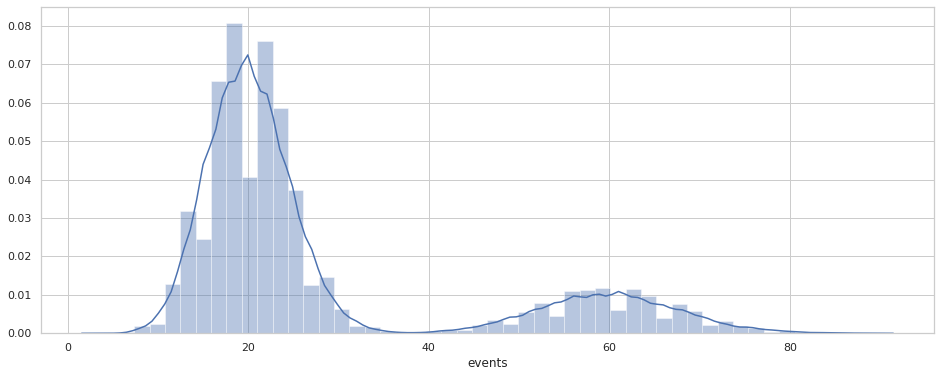

In [26]:
sns.distplot(delivery_button.query('group == "control"').events);

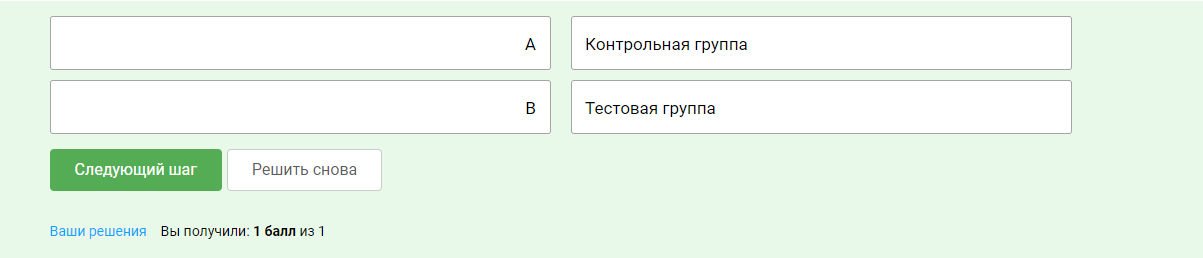

Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

В качестве ответа укажите стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки.

In [28]:
delivery_button.groupby(['group','segment']).events.describe().round(2)

count   mean   std   min   25%   50%   75%    max
group   segment                                                     
control high     10000.0  59.97  7.81  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.03  4.47   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.94  8.40  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.03  5.72  13.0  29.0  33.0  37.0   59.0

Почти у цели – осталось выбрать формулу для модели. Напомним, что мы хотим проверить эффект нескольких переменных – group и segment на events, с взаимодействием факторов.

Какую формулу используете?

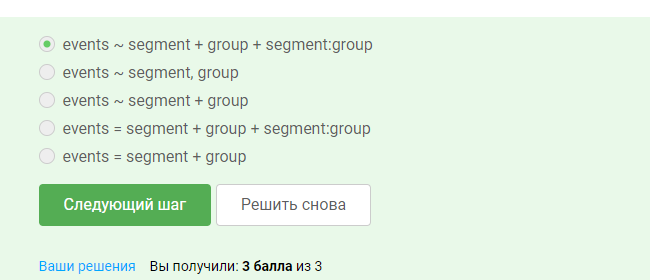

Проведите тест, а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison:
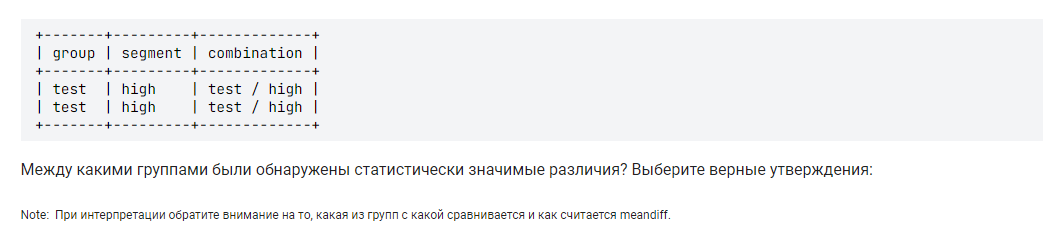

In [30]:
model = smf.ols(formula = 'events ~ segment + group + segment:group', data = delivery_button).fit()
aov_table = anova_lm(model, typ = 2)

In [31]:
print(round(aov_table, 2))

                    sum_sq       df          F  PR(>F)
segment        23624796.65      1.0  689756.38     0.0
group           3837195.41      1.0  112031.86     0.0
segment:group     36642.44      1.0    1069.82     0.0
Residual        3424955.89  99996.0        NaN     NaN


In [32]:
delivery_button['combination'] = delivery_button.group + ' \ ' + delivery_button.segment

In [39]:
delivery_button.combination.unique()

array(['test \\ high', 'control \\ high', 'test \\ low', 'control \\ low'],
      dtype=object)

In [34]:
print(pairwise_tukeyhsd(delivery_button.events, groups = delivery_button.combination).summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control \ high control \ low -39.9392 0.001 -40.1073 -39.7711   True
control \ high   test \ high   9.9677 0.001   9.7551  10.1803   True
control \ high    test \ low -26.9449 0.001  -27.113 -26.7768   True
 control \ low   test \ high  49.9069 0.001  49.7388   50.075   True
 control \ low    test \ low  12.9944 0.001   12.888  13.1007   True
   test \ high    test \ low -36.9126 0.001 -37.0807 -36.7445   True
--------------------------------------------------------------------


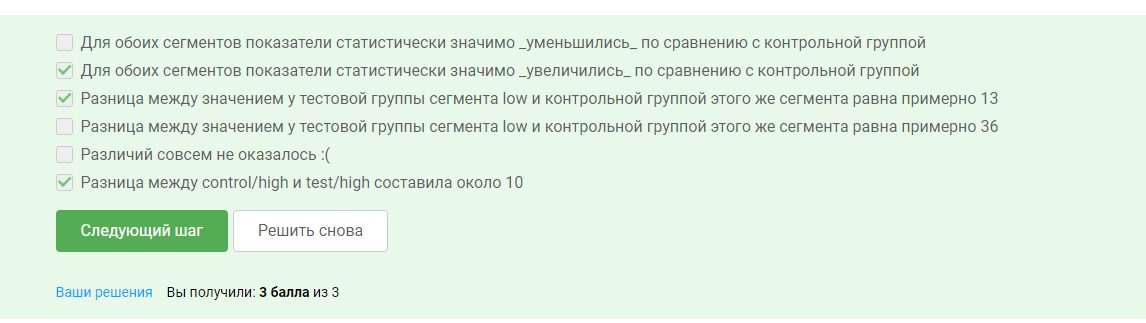

Визуализируйте результаты теста и заполните пропуски:



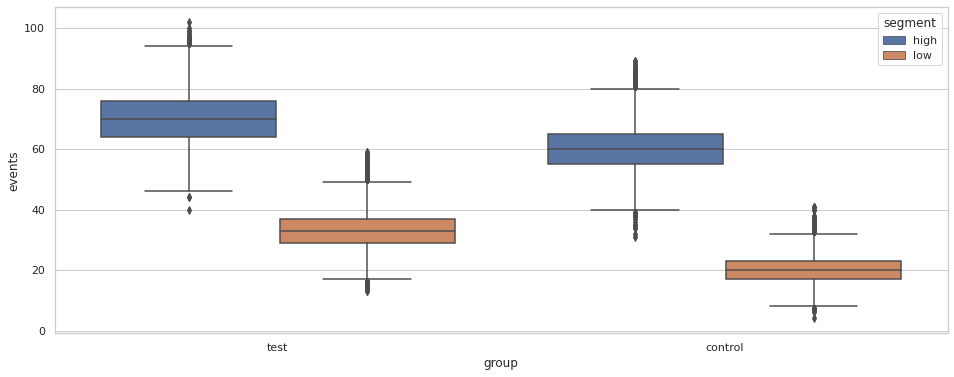

In [41]:
sns.boxplot(x = 'group', y = 'events', hue = 'segment', data = delivery_button);

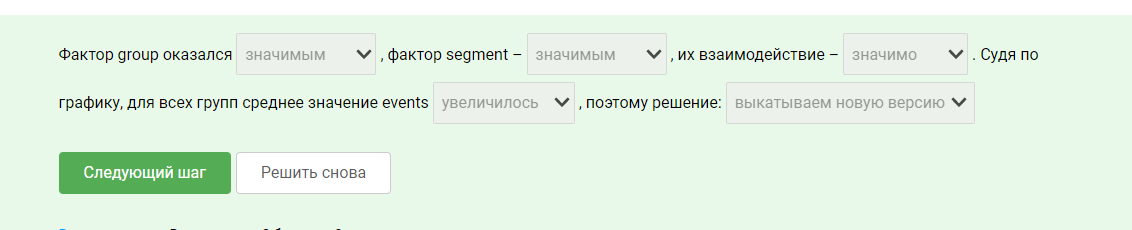